# Tuberculosis Genome-Wide Association Study analysis

## 01. Data pre-processing

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("geno_pheno_table_strings.csv", index_col=0).reset_index(drop=True)
data

,isolate_ID,group,ROLLINGDB_ID,RIF_midpoint,71,371,1849,1977,3439,3446,...,4408094,4408156,4408413,4408528,4408920,4408923,4409954,4410309,4410386,4411016
0,00R0223,4C,00R0223,1.00,C,C,C,A,G,C,...,C,A,G,G,A,C,G,G,G,G
1,00R0312,4B,00R0312,1.00,C,C,C,G,G,C,...,C,C,G,G,A,C,G,G,G,G
2,00R0435,4C,00R0435,1.00,C,C,C,A,G,C,...,C,A,G,G,A,C,G,G,G,G
3,00R0453,4B,00R0453,1.00,C,C,C,G,G,C,...,C,C,G,G,A,C,G,G,G,G
4,00R1566,4A,00R1566,1.00,C,C,C,G,G,C,...,C,A,G,A,A,C,G,G,G,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,TDR94S189L002,4A,TDR94S189L002,0.25,C,C,C,G,G,C,...,C,A,G,G,A,C,G,G,G,G
1517,TDR95S190L002,4A,TDR95S190L002,0.25,C,C,C,G,G,C,...,C,A,G,G,A,C,G,G,G,G
1518,TDR96S191L002,2,TDR96S191L002,0.25,C,C,A,G,G,C,...,C,A,G,G,A,T,G,G,G,G
1519,TDR99S194L002,2,TDR99S194L002,3.00,C,C,A,G,G,C,...,C,A,G,G,A,T,G,G,G,G


This project uses a dataset of 1521 Mycobacterium tuberculosis isolates, each represented by a single row. The columns labeled isolate_ID and ROLLINGDB_ID provide equivalent unique identifiers for each isolate, while the “group” column indicates the isolate’s phylogenetic classification. The “RIF_midpoint” column holds the minimum inhibitory concentration (MIC) for rifampicin, which is my primary measure of resistance (higher MIC values correspond to greater resistance).

There are several thousand columns that represent genomic positions based on the M. tuberculosis H37Rv reference genome (using 1-based indexing). Each position in this dataset is known to carry a minor allele in at least some of the isolates, and I’ve restricted these columns to those with a ≥1% minor allele frequency to simplify the analysis (the full dataset originally contained around 760,000 variant positions).

### 01. Data Matrix Overview

The data matrix contains genotype and phenotype data for **1521 *Mycobacterium tuberculosis* isolates**. Each row corresponds to a unique isolate (where `isolate_ID` and `ROLLINGDB_ID` are equivalent identifiers). The `group` column indicates the **phylogenetic classification**, and the `RIF_midpoint` column provides the **minimum inhibitory concentration (MIC)** for **rifampicin** (our phenotype). A higher MIC value means the isolate is more resistant.

All remaining columns represent **1-indexed genomic positions** in the *M. tuberculosis* H37Rv reference genome. Each position includes a **minor allele** in some isolates. To reduce data size, I applied a **≥1% minor allele frequency** filter. Originally, there were over **760K** variable positions, most of which did not meet this threshold.


In [19]:
encoded_data = data.copy()

encoded_data.iloc[:, 4:] = encoded_data.iloc[:, 4:].apply(lambda col: (col != col.value_counts().idxmax()).astype(int))

print(encoded_data.shape)

encoded_data.head()

(1521, 6002)


,isolate_ID,group,ROLLINGDB_ID,RIF_midpoint,71,371,1849,1977,3439,3446,...,4408094,4408156,4408413,4408528,4408920,4408923,4409954,4410309,4410386,4411016
0,00R0223,4C,00R0223,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00R0312,4B,00R0312,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,00R0435,4C,00R0435,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00R0453,4B,00R0453,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,00R1566,4A,00R1566,1.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### With one-hot encoding, you'd end up with 23,992 columns, so your matrix would be 1521 rows by 23,992 columns.

## 02. Perform a basic GWAS

### 02A. Setting Up the Phenotype Vector

I first created a vector `Y` from the `RIF_midpoint` column, taking the natural log of the raw MIC values to account for their exponential distribution. This transformation yields a NumPy array of shape (1521, 1):

In [4]:
Y = np.log(data['RIF_midpoint']).values.reshape(-1, 1)



In [7]:
def p_value_calculation(X2, reg):
    '''
    Parameters:
    X2: np.array, the data on which the model was fit
    reg: a fit sklearn.linear_model.LinearRegression

    Returns:
    an np.array containing the p-values for the intercept and the coefficients 
    Note that the first p-value will correspond to the intercept - the function prepends a ones column to X2
    
    '''
    
    X2 = X2.astype(float)
    
    #### This chunk of code computes the p-values for the regression coefficients, which sklearn doesn't do automatically
    beta_hat = [reg.intercept_] + reg.coef_.tolist()
    n = X2.shape[0]
    
    # compute the p-values
    from scipy.stats import t
    # add ones column
    X1 = np.column_stack((np.ones(n), X2))

    # standard deviation of the noise.
    sigma_hat = np.sqrt(np.sum(np.square(Y - X1@beta_hat)) / (n - X1.shape[1]))
    
    # estimate the covariance matrix for beta 
    beta_cov = np.linalg.inv(X1.T@X1)
    
    # the t-test statistic for each variable 
    t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
    
    # compute 2-sided p-values.
    p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
    
    return p_vals

### 02B. Testing Genotype-Phenotype Associations

For each genotype feature, I run a **simple linear regression** to evaluate whether that feature is associated with my phenotype (`log(RIF_midpoint)`). Specifically, I loop through the genotype columns in my encoded DataFrame, fit a scikit-learn `LinearRegression` model with default parameters, and then extract the **p-value**, **beta** coefficient, and the **genomic position** (snp_position).

After collecting all the results, I sort them by p-value and show the top five hits:

In [9]:
results = []

# genotype columns (features)
for col in encoded_data.columns[4:]:
    X = encoded_data[[col]].values.reshape(-1, 1)
    y = np.log(data['RIF_midpoint']).values
    
    # linear regression model
    model = LinearRegression().fit(X, y)
    beta = model.coef_[0]
    
    y_pred = model.predict(X)
    residuals = y - y_pred
    degrees_of_freedom = X.shape[0] - 2
    
    s_err = np.sqrt(np.sum(residuals**2) / degrees_of_freedom)
    X_std = np.std(X, ddof=1)
    se_beta = s_err / (np.sqrt(np.sum((X - np.mean(X))**2)))
    
    t_stat = beta / se_beta
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=degrees_of_freedom))
    
    results.append({"snp_position": col, "p_value": p_value, "beta": beta})

results_df = pd.DataFrame(results).sort_values(by="p_value").reset_index(drop=True)

results_df.head()

,snp_position,p_value,beta
0,2134215,0.0,0.985116
1,4320050,0.0,1.010421
2,761155,0.0,2.134091
3,736710,0.0,0.999113
4,2155168,0.0,-1.593196


### 02C: After applying a raw p-value threshold of 0.001, 2,377 hits would be significant.

In [10]:
significant_hits_count = (results_df['p_value'] < 0.001).sum()
significant_hits_count

2377

### 02D. After implementing a bonferroni correction for my p-values at alpha = 0.001, 615 hits are significant

In [11]:
alpha = 0.001
num_tests = len(results_df)

bonferroni_threshold = alpha / num_tests

significant_hits_bonferroni = (results_df['p_value'] < bonferroni_threshold).sum()
print("Number of significant hits after Bonferroni correction:", significant_hits_bonferroni)



Number of significant hits after Bonferroni correction: 615


In [21]:
# checking my work using the multipletests function from statsmodels.stats.multitest
from statsmodels.stats.multitest import multipletests

alpha = 0.001
p_values = results_df['p_value'].values
_, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

significant_hits_bonferroni = (corrected_p_values < alpha).sum()
print("Number of significant hits after Bonferroni correction (using multipletests):", significant_hits_bonferroni)



Number of significant hits after Bonferroni correction (using multipletests): 615


### 02E. Visualizing Results with a Manhattan Plot

To visualize the distribution of association signals across the genome, I created a **Manhattan plot**. Here, `snp_position` is shown on the x-axis, and the **-log10 of the p-value** is plotted on the y-axis. I also overlaid horizontal reference lines for both the **uncorrected** p-value threshold and the **Bonferroni-corrected** threshold, using `plt.axhline()`.


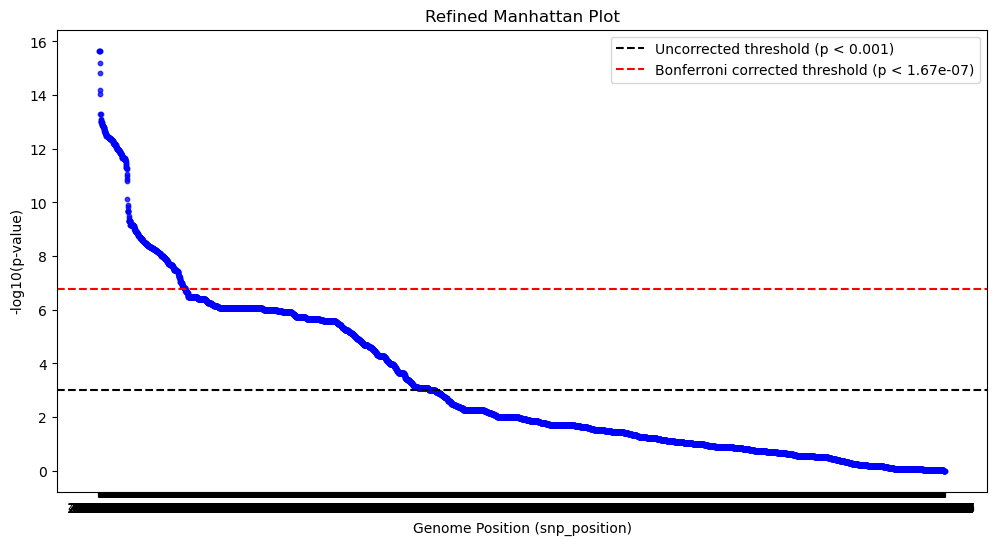

In [23]:
# Thresholds
uncorrected_threshold = 0.001
corrected_threshold = 0.001 / len(results_df)

plt.figure(figsize=(12, 6))

# -log10(p_value) vs. snp_position
plt.scatter(
    results_df['snp_position'],
    -np.log10(results_df['p_value']),
    alpha=0.75, 
    c='blue', 
    s=10
)

# Raw p-value thresholds to -log10 scale and add horizontal lines
plt.axhline(
    y=-np.log10(uncorrected_threshold),
    color='black',
    linestyle='--',
    label=f'Uncorrected threshold (p < {uncorrected_threshold})'
)
plt.axhline(
    y=-np.log10(corrected_threshold),
    color='red',
    linestyle='--',
    label=f'Bonferroni corrected threshold (p < {corrected_threshold:.2e})'
)

plt.xlabel('Genome Position (snp_position)')
plt.ylabel('-log10(p-value)')
plt.title('Refined Manhattan Plot')
plt.legend()
plt.show()

### 02F: Did using the bonferroni correction increase or decrease the number of significant hits? Why?

#### Applying the Bonferroni correction decreased the number of significant hits. This is because the Bonferroni correction is a conservative adjustment that lowers the threshold for significance to account for multiple comparisons, reducing the likelihood of false positives by requiring more stringent evidence to declare a result as significant.